In [1]:
# 3L_SDVRP

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multinomial
from scipy.stats import dirichlet
from py3dbp import Packer, Bin, Item
import math
import random
%matplotlib inline
import pylab as pl
from IPython import display
import neshan

# "rnd" is an object that generate random numbers
rnd = np.random
#"seed(0)" is a method that reset (every time), the same random set of numbers
rnd.seed(0)
# Number of collection points
n_customer = 5
# The set of nodes without the depot.
N = [i for i in range(1,n_customer+1)]
# The set of nodes + the depot.
V = [0]+ N
# The Number of cargoes
Cat = 9
# Generating items for each collection point
IT = []
for i in N:
    cargo_set_=[]
    for j in range (1,Cat + 1):
        cargo_set_.append({(i,j):[rnd.randint(1, kk) for kk in [10,10,10,100]]})
    IT.append(cargo_set_)
IT_num = [(i,j) for i in N for j in range(1, Cat + 1)]
# Number of Vehicles
nv = 3
# Max volume and Max weight that each vehicle can carry
Container_vehicle = [('vehicle_%d'%kk, rnd.randint(30, 50), rnd.randint(30, 50), rnd.randint(30, 50), rnd.randint(100, 500)) for kk in range(0,nv) ]

# Defining coordinates of collection points
Locations = pd.DataFrame()
xc = [35.730250, 35.716169, 35.716749, 35.736719, 35.766557, 35.767301]
yc = [51.334336, 51.366407, 51.407847, 51.416115, 51.375811, 51.428972]
Locations['Latitude'] = xc
Locations['Longitude'] = yc
locationtuples = [tuple(x) for x in Locations.to_numpy()]
# The number of Routing plans
RP = 10
# Intializing the set of arcs A.
A = [(i,j) for i in V for j in V if i!=j]
# Calculating the distance between each node as non-negative cost of each arc
# using neshan api (Iranian map services provider) for calculating distances between each pair of points
nmaps = neshan.Client(key='service.PNVDAoZ5IqhevfM0KSCfVlwyXTbjXrbNf7rQvqVe')
distance_matrix_result = nmaps.distance_matrix(locationtuples,locationtuples)
dist= {(i, j): distance_matrix_result["rows"][i]["elements"][j]["duration"]["value"] for i, j in A}
# Generating historical data wich show how many times each route has been chosen
historical_routes = [rnd.randint(1, 100)/100 for i in range(0, len(A))]

In [3]:
# Vehicle Route Planning Module

def findRoutPlans(alpha):

    # Drichlet distribution of routes
    multinomial_ed=[]
    for alpha_inside in alpha:
        drichlet_mean = dirichlet.mean(alpha_inside)
        multinomial_ed.append(multinomial.rvs(300, drichlet_mean, size=RP*2))

    # Finding Edges
    init_final_path = []
    final_path =[]
    for eachroute in multinomial_ed:
        semi_final_path = []
        for routplansiterator in range(0, len(eachroute)):
            sorted_edges=[]
            for maxifinder in range(max(eachroute[routplansiterator]), -1, -1):
                finded = np.where(eachroute[routplansiterator] == maxifinder)
                sorted_edges.append(finded[0])
            first_path = []
            for sedge in sorted_edges:
                for seg in sedge:
                    # Checking for duplicate collection points
                    if len(first_path) > 0:
                        first_elements = [i for i,j in first_path]
                        second_elements = [j for i,j in first_path]
                        if A[seg][0] not in first_elements and A[seg][1] not in second_elements:
                            first_path.append(A[seg])
                    else:
                        first_path.append(A[seg])
            if len(first_path) > n_customer:        
                semi_final_path.append(first_path[0:(n_customer + 2)])

        # Removing invalid routes
        numfailed = []
        for rpiterator in range(0,len(semi_final_path)):
            starting_point=0
            for jkl in semi_final_path[rpiterator]:
                starting_point=starting_point+1
                for lkj in semi_final_path[rpiterator][starting_point:]:
                    if (jkl[1] == lkj[0] and jkl[0] == lkj[1]):
                        numfailed.append(rpiterator)
                        
        clear_paths = [i for n, i in enumerate(semi_final_path) if n not in numfailed]
        init_final_path.append(clear_paths)

    # Choosing different paths for every vehicle between existing rouyte plans
    d = 0
    final_path =[]
    for i in range(0,len(init_final_path)):
        a = init_final_path[i][d]
        final_path.append(a)
        for j in range(i+1,min(i+2, len(init_final_path))):
            p=[]
            for k in range(0, len(init_final_path[j])):
                p.append(len(set(a) & set(init_final_path[j][k])))
        d = p.index(min(p))
    return final_path


In [4]:
# Splitting Module

def splitCargoes(alpha_s, nv):
    
    # Drichlet distribution of plans
    multinomial_ed_s=[]
    for alpha_s_inside in alpha_s:
        drichlet_mean_s = dirichlet.mean(alpha_s_inside)
        multinomial_ed_s.append(multinomial.rvs(300, drichlet_mean_s, size=1))
    
    # Choosing Cargoes
    final_set = []
    
    for cargoewclassiterator in range(0, len(multinomial_ed_s)):
        sorted_cargoes=[]
        for maxfinder in range(max(multinomial_ed_s[cargoewclassiterator][0]), -1, -1):
            if maxfinder>0:
                finded_cargoes = np.where(multinomial_ed_s[cargoewclassiterator][0] == maxfinder)
                sorted_cargoes.append(finded_cargoes[0])

        first_set = []
        for hh in sorted_cargoes:
            for ff in hh:
                first_set.append(IT[cargoewclassiterator][ff])
        final_set.append([first_set])

    # Cargoes for vehicles
    set_for_vehicles=[]

    for vehicle_num in range(0,nv):
        init_set=[]
        for custom_num in range(0,n_customer):
            init_set.append(final_set[custom_num][0][vehicle_num*round(Cat/nv):vehicle_num*round(Cat/nv)+round(Cat/nv)])
        set_for_vehicles.append(init_set)

    return set_for_vehicles, final_set

In [5]:
# Optimal 3D Loading Module

def loading(Container_vehicle, final_set):

    packer = Packer()
    # The maximum volum and weight that a container can carry (length, width, height, weight)
    # Add bins
    packer.add_bin(Bin(Container_vehicle[0],
                        Container_vehicle[1],
                        Container_vehicle[2],
                        Container_vehicle[3],
                        Container_vehicle[4]))

    # add items to corresponding containers
    for customeritems in final_set:
        for items in customeritems:
            packer.add_item(Item(list(items.keys())[0],
                                list(items.values())[0][0],
                                list(items.values())[0][1],
                                list(items.values())[0][2],
                                list(items.values())[0][3]))

    packer.pack(number_of_decimals=0)

    return packer

In [6]:
# Function to Calculate Fitness Function 1

def fitnessFunction_1(pop):

    F1=[]
    for vehicles in range(0, len(pop)):
        route_cost = 0
        for i in pop[vehicles]:
            route_cost = route_cost + dist[i]
        F1.append(route_cost)

    return sum(F1)

In [7]:
# Function to calculate Fitness Function 2

def fitnessFunction_2(pc_items, pc_bins):

    # Calculate each container capacity
    containers_weight = [wgh[4] for wgh in Container_vehicle]
    containers_volume = [vol[1]*vol[2]*vol[3] for vol in Container_vehicle]

    # Calculate all items wgh and vol
    items_weight = []
    items_volume = []

    for boxes in pc_items:
        items_weight.append(sum([float(item.weight) for item in boxes]))
        items_volume.append(sum([float(item.get_volume()) for item in boxes]))

    # total_items_weight = np.array(items_weight)
    # total_items_volume = np.array(items_volume)

    # rvol_mean = np.sum(total_items_volume)/sum(containers_volume)
    # rwgh_mean = np.sum(total_items_weight)/sum(containers_weight)

    rvol = sum(items_volume)
    rwgh = sum(items_weight)
    
    rvol_mean = sum(items_volume)/sum(containers_volume)
    rwgh_mean = sum(items_weight)/sum(containers_weight)

    # Calculate each vehicle bins items wgh and vol
    bins_fitteditems_weight = []
    bins_fitteditems_volume = []

    for contain in pc_bins:
        bins_fitteditems_weight.append(sum([float(item.weight) for item in contain[0].items]))
        bins_fitteditems_volume.append(sum([float(item.get_volume()) for item in contain[0].items]))

    # fitted_items_weight = np.array(bins_fitteditems_weight)
    # fitted_items_volume = np.array(bins_fitteditems_volume)

    # total_fitteditems_wgh = sum(np.sum(fitted_items_weight))
    # total_fitteditems_vol = sum(np.sum(fitted_items_volume))

    total_fitteditems_wgh = sum(bins_fitteditems_weight)
    total_fitteditems_vol = sum(bins_fitteditems_volume)

    F2 = rvol + rwgh - total_fitteditems_vol - total_fitteditems_wgh

    return F2

In [8]:
# Function to find index of list

def index_of(a,list):
    for i in range(0,len(list)):
        if list[i] == a:
            return i

    return -1

In [9]:
# Function to sort by values

def sort_by_values(list1, values):
    sorted_list = []
    while(len(sorted_list)!=len(list1)):
        if index_of(min(values),values) in list1:
            sorted_list.append(index_of(min(values),values))
        values[index_of(min(values),values)] = math.inf

    return sorted_list

In [10]:
# Function to calculate NSGA_II's crowding distance

def crowding_distance(values1, values2, front):

    distance = [0 for i in range(0,len(front))]
    sorted1 = sort_by_values(front, values1[:])
    sorted2 = sort_by_values(front, values2[:])
    distance[0] = 999999999999999
    distance[len(front) - 1] = 999999999999999

    for k in range(1,len(front)-1):
        if (max(values1)-min(values1) == 0):
            distance[k] = 999999999999999
        else:
            distance[k] = distance[k]+ (values1[sorted1[k+1]] - values2[sorted1[k-1]])/(max(values1)-min(values1))
    for k in range(1,len(front)-1):
        if (max(values2)-min(values2) == 0):
            distance[k] = 999999999999999
        else:
            distance[k] = distance[k]+ (values2[sorted2[k+1]] - values2[sorted2[k-1]])/(max(values2)-min(values2))

    return distance

In [11]:
# Function to carry out NSGA-II's non dominated sort

def fast_non_dominated_sort(values1, values2):

    S=[[] for i in range(0,len(values1))]
    front = [[]]
    n=[0 for i in range(0,len(values1))]
    rank = [0 for i in range(0, len(values1))]

    for p in range(0,len(values1)):
        S[p]=[]
        n[p]=0
        for q in range(0, len(values1)):
            if (values1[p] < values1[q] and values2[p] < values2[q]) or (values1[p] <= values1[q] and values2[p] < values2[q]) or (values1[p] < values1[q] and values2[p] <= values2[q]):
                if q not in S[p]:
                    S[p].append(q)
            elif (values1[q] < values1[p] and values2[q] < values2[p]) or (values1[q] <= values1[p] and values2[q] < values2[p]) or (values1[q] < values1[p] and values2[q] <= values2[p]):
                n[p] = n[p] + 1
        if n[p]==0:
            rank[p] = 0
            if p not in front[0]:
                front[0].append(p)

    i = 0
    while(front[i] != []):
        Q=[]
        for p in front[i]:
            for q in S[p]:
                n[q] =n[q] - 1
                if( n[q]==0):
                    rank[q]=i+1
                    if q not in Q:
                        Q.append(q)
        i = i+1
        front.append(Q)
    del front[len(front)-1]
    
    return front

In [12]:
# Function to carry out the NSGA_II's crossover

def crossover(pop1,pop2):

    mutation_prob = random.random()

    if mutation_prob > 0.8:
        pop1, pop2 = mutation(pop1, pop2)
    else:
        r1 = np.random.randint(0, len(pop1['route']))
        r2 = np.random.randint(0, len(pop1['route']))

        route_1 = pop1['route'][r1]
        route_2 = pop2['route'][r2]
        pop1['route'][r1] = route_2
        pop2['route'][r2] = route_1

        r3 = np.random.randint(0, len(pop1['set'][0]))

        for i in range(0,len(pop1['set'])):
            set_1 = pop1['set'][i][r3]
            set_2 = pop2['set'][i][r3]
            pop1['set'][i][r3] = set_2
            pop2['set'][i][r3] = set_1

    return pop1, pop2


In [13]:
# Function to carry out the mutation operator
def mutation(pop1, pop2):
    r_ = random.random()
    r1 = np.random.randint(1, len(pop1['set']))
    r2 = np.random.randint(1, len(pop1['set']))
    if r_ > 0.5:
        set_1 = pop1['set'][r1]
        set_2 = pop1['set'][r2]
        pop1['set'][r1] = set_2
        pop1['set'][r2] = set_1
    else:
        set_1 = pop2['set'][r1]
        set_2 = pop2['set'][r2]
        pop2['set'][r1] = set_2
        pop2['set'][r2] = set_1

    return pop1, pop2

In [14]:
# Function to init the first population and update the distribution matrix
def InitializePopulation(pop_size, max_gen):

    route_prob = []
    for j in range(0, len(Container_vehicle)):
        route_prob.append(historical_routes)
    alpha = route_prob  ### alpha is an array of our historical data for each edge

    split_prob=[]
    for i in range (0, n_customer):
        split_prob.append([1 for i in range(0, len(IT[0]))])
    alpha_s = split_prob     ### alpha_s is an uniform array for splitting plan

    pop_size = pop_size
    pop = {}
    max_gen = max_gen
    gen_no = 0
    pltF1 = []
    pltF2 = []

    while(gen_no<max_gen):

        # Calculate fitness functions for generated population
        for ind in range(0,pop_size):
            final_path = findRoutPlans(alpha)
            set_per_vehic, total_sets = splitCargoes(alpha_s, nv)
            pc_bins = []
            pc_items = []
            counter_sets = 0
            for vehicle_count in range(0,len(Container_vehicle)):
                pc = loading(Container_vehicle[vehicle_count], set_per_vehic[counter_sets])
                pc_bins.append(pc.bins)
                pc_items.append(pc.items)
                counter_sets = counter_sets + 1

            fitness_1 = fitnessFunction_1(final_path)
            fitness_2 = fitnessFunction_2(pc_items, pc_bins)

            pop[ind] = {
                        'route': final_path,
                        'set': set_per_vehic,
                        'pack_bins': pc_bins,
                        'pack_items': pc_items,
                        'F1': fitness_1,
                        'F2': fitness_2
                        } 

        # Best Pareto Front
        objective1_values = [float(pop[i]['F1']) for i in range(0,len(pop))]
        objective2_values = [float(pop[i]['F2']) for i in range(0,len(pop))]
        
        # Find index of best route plan
        best_route_plan = index_of(min(objective1_values), objective1_values)
        # Find index of best splitting plan
        best_split_plan = index_of(min(objective2_values), objective2_values)
        # Updating routes distribution matrix
        for route_min in range(0, len(pop[best_route_plan]['route'])):
            for edge in pop[best_route_plan]['route'][route_min]:
                index = index_of(edge, A)
                alpha[route_min][index] = alpha[route_min][index] + 0.05

        # Updating Splitting distribution matrix
        maxcoefficient = len(pop[best_split_plan]['set'])
        for plans in pop[best_split_plan]['set']:
            maxcoefficient = maxcoefficient -1
            for node_min in plans:
                ak = 0
                for clus_1 in node_min :
                    ak = ak + 1
                    alpha_s[list(clus_1.keys())[0][0] - 1][list(clus_1.keys())[0][1] - 1] = alpha_s[list(clus_1.keys())[0][0] - 1][list(clus_1.keys())[0][1]-1] + (10*maxcoefficient)

        function1 = [i for i in objective1_values]
        function2 = [j for j in objective2_values]

        pltF1.append(sum(function1)/len(function1))
        pltF2.append(sum(function2)/len(function2))
        # pltF1.append(min(function1))
        # pltF2.append(min(function2))
        

        # Plot Fitness functions values

        fit1 = pltF1
        fit2 = pltF2
        
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        ax1.plot(fit1, 'r-')
        ax1.set_ylabel('Fitness_1', color='r')
        for rl in ax1.get_yticklabels():
            rl.set_color('r')

        ax2 = ax1.twinx()
        ax2.plot(fit2, 'b-')
        ax2.set_ylabel('Fitness_2', color='b')
        for tl in ax2.get_yticklabels():
            tl.set_color('b')
        plt.ioff()
        plt.ion()
        display.clear_output(wait=True)

        plt.show()
        display.display(gen_no)

        gen_no = gen_no + 1

    return pop


In [15]:
# Function to do NSGA_II to find the best plan

def NSGA_II_main(pop, max_gen):

        max_gen = max_gen
        gen_no = 0
        pltF1 = []
        pltF2 = []
        pltF1min = []
        pltF2min = []
        function1 = []
        function2 = []
        pop_size = 2*len(pop)

        route_prob = []
        for j in range(0, len(Container_vehicle)):
                route_prob.append([1 for i in range(0, len(historical_routes))])
        alpha = route_prob  ### alpha is an array of our historical data for each edge

        split_prob=[]
        for i in range (0, n_customer):
                split_prob.append([1 for i in range(0, len(IT[0]))])
        alpha_s = split_prob     ### alpha_s is an uniform array for splitting plan

        for ind in range(int(pop_size/2), pop_size):
                final_path = findRoutPlans(alpha)
                set_per_vehic, total_sets = splitCargoes(alpha_s, nv)
                pc_bins = []
                pc_items = []
                counter_sets = 0
                for vehicle_count in range(0,len(Container_vehicle)):
                        pc = loading(Container_vehicle[vehicle_count], set_per_vehic[counter_sets])
                        pc_bins.append(pc.bins)
                        pc_items.append(pc.items)
                        counter_sets = counter_sets + 1

                fitness_1 = fitnessFunction_1(final_path)
                fitness_2 = fitnessFunction_2(pc_items, pc_bins)

                pop[ind] = {
                        'route': final_path,
                        'set': set_per_vehic,
                        'pack_bins': pc_bins,
                        'pack_items': pc_items,
                        'F1': fitness_1,
                        'F2': fitness_2
                        }
        while(gen_no<max_gen):

                # None dominated sorting for the generated population
                objective1_values = [float(pop[i]['F1']) for i in range(0,len(pop))]
                objective2_values = [float(pop[i]['F2']) for i in range(0,len(pop))]
                non_dominated_sorted_solution = fast_non_dominated_sort(objective1_values[:],objective2_values[:])
                
                # Calculate Crowding distance for fronts
                crowding_distance_values=[]

                for i in range(0,len(non_dominated_sorted_solution)):
                        crowding_distance_values.append(crowding_distance(objective1_values[:], objective2_values[:], non_dominated_sorted_solution[i][:]))

                # Generating new population through crossover nd mutation
                pop2 = {}
                for i in range(0, len(pop)):
                        pop2[i] = pop[i]

                ll=len(pop)
                while(len(pop2) < 2*pop_size):
                        a1 = random.randint(0,pop_size-1)
                        b1 = random.randint(0,pop_size-1)
                        
                        # Crossover and mutation
                        off_1, off_2 = crossover(pop[a1],pop[b1])
                        pop2[ll] = off_1
                        pop2[ll+1] = off_2

                        pc1_bins = []
                        pc1_items = []
                        pc2_bins = []
                        pc2_items = []
                        counter_sets = 0
                        
                        # Calculate fitness functions for newly generated offsprings
                        for vehicle_count in range(0,len(Container_vehicle)):
                                pc_1 = loading(Container_vehicle[vehicle_count], pop2[ll]['set'][counter_sets])
                                pc_2 = loading(Container_vehicle[vehicle_count], pop2[ll+1]['set'][counter_sets])
                                pc1_bins.append(pc_1.bins)
                                pc1_items.append(pc_1.items)
                                pc2_bins.append(pc_2.bins)
                                pc2_items.append(pc_2.items)
                                counter_sets = counter_sets + 1

                        pop2[ll]['pack_bins'] = pc1_bins
                        pop2[ll]['pack_items'] = pc1_items
                        pop2[ll+1]['pack_bins'] = pc2_bins
                        pop2[ll+1]['pack_items'] = pc2_items

                        fitness_1_off_1 = fitnessFunction_1(pop2[ll]['route'])
                        fitness_2_off_1 = fitnessFunction_2(pop2[ll]['pack_items'], pop2[ll]['pack_bins'])
                        fitness_1_off_2 = fitnessFunction_1(pop2[ll+1]['route'])
                        fitness_2_off_2 = fitnessFunction_2(pop2[ll+1]['pack_items'], pop2[ll+1]['pack_bins'])

                        pop2[ll]['F1'] = fitness_1_off_1
                        pop2[ll]['F2'] = fitness_2_off_1
                        pop2[ll+1]['F1'] = fitness_1_off_2
                        pop2[ll+1]['F2'] = fitness_2_off_2
                        ll= ll + 2
                
                #None dominated sorting of new generation
                objective1_values2 = [float(pop2[i]['F1']) for i in range(0,len(pop2))]
                objective2_values2 = [float(pop2[i]['F2']) for i in range(0,len(pop2))]
                non_dominated_sorted_solution2 = fast_non_dominated_sort(objective1_values2[:],objective2_values2[:])
                
                # Crowding distance of new generation
                crowding_distance_values2=[]
                for i in range(0,len(non_dominated_sorted_solution2)):
                        crowding_distance_values2.append(crowding_distance(objective1_values2[:],objective1_values2[:],non_dominated_sorted_solution2[i][:]))
                
                # Ranking Solutions and replacing older solutions
                new_solution= []
                for i in range(0,len(non_dominated_sorted_solution2)):
                        non_dominated_sorted_solution2_1 = [index_of(non_dominated_sorted_solution2[i][j],non_dominated_sorted_solution2[i] ) for j in range(0,len(non_dominated_sorted_solution2[i]))]
                        front22 = sort_by_values(non_dominated_sorted_solution2_1[:], crowding_distance_values2[i][:])
                        front = [non_dominated_sorted_solution2[i][front22[j]] for j in range(0,len(non_dominated_sorted_solution2[i]))]
                        front.reverse()
                        for value in front:
                                new_solution.append(value)
                                if(len(new_solution)==pop_size):
                                        break
                        if (len(new_solution) == pop_size):
                                break
                # Replacing Older solutions
                pop.clear()
                for sol in range(0, len(new_solution)):
                        pop[sol] = pop2[new_solution[sol]]
                
                # Store fitness values
                function1 = function1 + [i * 1 for i in objective1_values]
                function2 = function2 + [j * 1 for j in objective2_values]
                # function1 = [objective1_values[i] for i in non_dominated_sorted_solution[0]]
                # function2 = [objective2_values[j] for j in non_dominated_sorted_solution[0]]

                # pltF1.append(sum(function1)/len(function1))
                # pltF2.append(sum(function2)/len(function2))
                pltF1.append(min(function1))
                pltF2.append(min(function2))

                # pl.clf()
                # pl.scatter(function1,function2)

                # display.clear_output(wait=True)
                # display.display(pl.gcf())
                # display.display(gen_no)

                # Plot Fitness functions values

                fit1 = pltF1
                fit2 = pltF2
                
                fig = plt.figure()
                ax1 = fig.add_subplot(111)
                ax1.plot(fit1, 'r-')
                ax1.set_ylabel('Fitness_1', color='r')
                for rl in ax1.get_yticklabels():
                        rl.set_color('r')

                ax2 = ax1.twinx()
                ax2.plot(fit2, 'b-')
                ax2.set_ylabel('Fitness_2', color='b')
                for tl in ax2.get_yticklabels():
                        tl.set_color('b')
                plt.ioff()
                plt.ion()
                display.clear_output(wait=True)

                plt.show()
                # pl.clf()
                # pl.scatter(function1,function2)
                display.display(gen_no)
                
                gen_no = gen_no + 1

        return pop


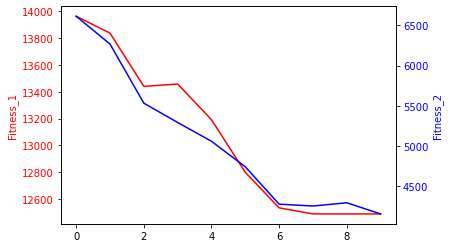

9

In [16]:
# Running the DTSA Module for producing routing and splitting plans

initpop = InitializePopulation(20, 10)

# Plot of the Objective function Values

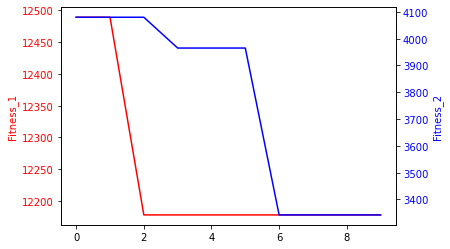

9

In [17]:
# Running The NSGA_II for finding the optimum solutions for SD-VRP problem

final_pop = NSGA_II_main(initpop, 10)

# Plot of the Objective function Values

In [18]:
# Sample Route plan
final_pop[0]['route'][0]


[(4, 3), (3, 5), (5, 2), (0, 4), (2, 1), (1, 0)]

In [19]:

route_sequence =[0]
k=0
for al in range(0,10):
    for i,j in final_pop[0]['route'][0]:
        if i == k:
            route_sequence.append(j)
            k=j
route_sequence

sequence_locations=[]
for i in route_sequence[0:n_customer+2] :
    sequence_locations.append(tuple(locationtuples[i]))
sequence_locations

[(35.73025, 51.334336),
 (35.766557, 51.375811),
 (35.736719, 51.416115),
 (35.767301, 51.428972),
 (35.716749, 51.407847),
 (35.716169, 51.366407),
 (35.73025, 51.334336)]

In [20]:
# directions_result = nmaps.directions(sequence_locations[0],
#                                     sequence_locations[-1],
#                                     sequence_locations[1:-1])

In [21]:
# directions_result[0]["overview_polyline"]["points"]

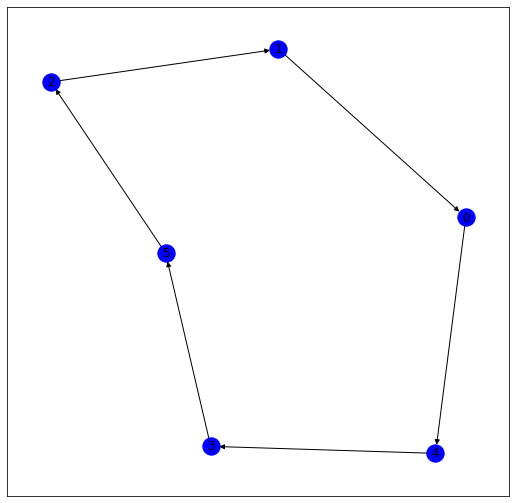

In [22]:
# Ploting Sample Route plan
import networkx as nx 
G = nx.DiGraph()
G.add_edges_from(final_pop[0]['route'][0]) 

plt.figure(figsize =(9, 9)) 
nx.draw_networkx(G, with_label = True, node_color ='blue') 

In [23]:
# Sample Splitted Plan

final_pop[0]['set'][0]

[[{(1, 7): [4, 6, 1, 83]}, {(1, 9): [4, 4, 8, 33]}, {(1, 8): [4, 9, 2, 30]}],
 [{(2, 7): [3, 1, 4, 54]}, {(2, 2): [4, 3, 8, 29]}, {(2, 3): [3, 1, 1, 37]}],
 [{(3, 5): [5, 3, 1, 94]}, {(3, 6): [4, 3, 1, 22]}, {(3, 8): [3, 3, 4, 95]}],
 [{(4, 5): [9, 9, 3, 4]}, {(4, 6): [3, 1, 9, 73]}, {(4, 4): [7, 4, 4, 57]}],
 [{(5, 5): [3, 9, 7, 80]}, {(5, 7): [9, 9, 4, 83]}, {(5, 9): [6, 8, 1, 12]}]]

In [24]:
# Remained Items that has not collected yet

remained_items = {}
for i in range(0,len(final_pop[0]['pack_bins'])):
    for j in range(0,len(final_pop[0]['pack_bins'][i][0].unfitted_items)):
        remained_items[final_pop[0]['pack_bins'][i][0].unfitted_items[j].name] = final_pop[0]['pack_bins'][i][0].unfitted_items[j].get_dimension()
remained_items


{(1, 7): [Decimal('4'), Decimal('6'), Decimal('1')],
 (4, 6): [Decimal('3'), Decimal('1'), Decimal('9')],
 (3, 8): [Decimal('3'), Decimal('3'), Decimal('4')],
 (1, 8): [Decimal('4'), Decimal('9'), Decimal('2')],
 (2, 2): [Decimal('4'), Decimal('3'), Decimal('8')],
 (4, 4): [Decimal('7'), Decimal('4'), Decimal('4')],
 (1, 9): [Decimal('4'), Decimal('4'), Decimal('8')],
 (5, 5): [Decimal('3'), Decimal('9'), Decimal('7')],
 (5, 7): [Decimal('9'), Decimal('9'), Decimal('4')],
 (1, 1): [Decimal('6'), Decimal('1'), Decimal('4')],
 (3, 3): [Decimal('2'), Decimal('6'), Decimal('4')],
 (2, 9): [Decimal('5'), Decimal('4'), Decimal('5')],
 (5, 8): [Decimal('4'), Decimal('7'), Decimal('4')],
 (2, 8): [Decimal('5'), Decimal('5'), Decimal('7')],
 (1, 6): [Decimal('9'), Decimal('5'), Decimal('4')],
 (3, 1): [Decimal('9'), Decimal('5'), Decimal('4')],
 (4, 2): [Decimal('7'), Decimal('9'), Decimal('3')],
 (1, 2): [Decimal('8'), Decimal('4'), Decimal('6')]}

In [25]:
### Now we just have to replace the IT variable with remained_items and run the whole algorithms againt to collect the remained items